In [1]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from HDDT import HDDT
from utils import perform_grid_search
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
class BaggingWithUndersampling:
    def __init__(self, n_estimators=10, samples_ceof=1.0, base_learner=DecisionTreeClassifier(), disable_under_sampling=False):
        self.n_estimators = n_estimators
        self.samples_ceof = samples_ceof
        self.base_learner = base_learner
        self.estimators = []
        self.disable_under_sampling = disable_under_sampling

    def fit(self, X, y):
        unique_labels, label_counts = np.unique(y, return_counts=True)
        majority_label = unique_labels[np.argmax(label_counts)]
        minority_label = unique_labels[np.argmin(label_counts)]

        minority_class_indices = np.where(y == minority_label)[0]
        majority_class_indices = np.where(y == majority_label)[0]

        for _ in range(self.n_estimators):
            base_estimator = self.base_learner
            if(self.disable_under_sampling):
                X_subset, y_subset = X, y
            else:
                majority_class_indices_sampled = np.random.choice(majority_class_indices,\
                                                                int(len(minority_class_indices) * self.samples_ceof), \
                                                                    replace=False)
                indices = np.concatenate((minority_class_indices, majority_class_indices_sampled))
                X_subset, y_subset = X[indices], y[indices]

            base_estimator.fit(X_subset, y_subset)
            self.estimators.append(base_estimator)

    def predict(self, X):
        predictions = np.array([estimator.predict(X) for estimator in self.estimators], dtype=int)
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)



In [3]:
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier

class AdaBoostUnderSampling:
    def __init__(self, base_learner, n_estimators=10, rounds=10):
        self.n_estimators = n_estimators
        self.rounds = rounds
        self.base_learner = base_learner
        self.estimators = []
        self.alphas = []

    def fit(self, X, y):
        unique_labels, label_counts = np.unique(y, return_counts=True)
        majority_label = unique_labels[np.argmax(label_counts)]
        minority_label = unique_labels[np.argmin(label_counts)]

        minority_class_indices = np.where(y == minority_label)[0]
        majority_class_indices = np.where(y == majority_label)[0]

        n = X.shape[0]

        for _ in range(self.n_estimators):
            weights = np.ones(n) / n
            
            for __ in range(self.rounds):
                majority_class_indices_sampled = np.random.choice(majority_class_indices, len(minority_class_indices), \
                                                                    replace=False)
                indices = np.concatenate((minority_class_indices, majority_class_indices_sampled))
                X_subset, y_subset = X[indices], y[indices]

                self.base_learner.fit(X_subset, y_subset)

                predictions = self.base_learner.predict(X)
                error = np.sum(weights[y != predictions])

                alpha = 0.5 * np.log((1 - error) / (error + 1e-10))

                weights *= np.exp(alpha * (predictions != y))
                weights /= np.sum(weights)

            self.estimators.append(self.base_learner)
            self.alphas.append(alpha)

    def predict(self, X):
        predictions = np.zeros(X.shape[0])

        for model, alpha in zip(self.estimators, self.alphas):
            predictions += np.array(alpha, dtype=np.float64) * model.predict(X)
        
        return np.sign(predictions)

In [4]:
import pandas as pd

data = np.array(pd.read_csv("Covid.csv"))
X = data[:, :-1]
y = data[:, -1]
cls_0 = np.where(y == -1)[0]
cls_1 = np.where(y == 1)[0]
y[cls_0] = 0
y[cls_1] = 1

unique_labels, label_counts = np.unique(y, return_counts=True)
minority_label = unique_labels[np.argmin(label_counts)]

In [5]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imp = IterativeImputer(max_iter=300, random_state=1, initial_strategy="most_frequent")
imp.fit(X)
X = np.round(imp.transform(X), 1)

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=2)

## Bagging

### Built-in Decision tree

Mean Evaluation Metrics:
+--------------+------------------+---------------+------------------+---------------+------------+-----------------+
| n_estimators | Precision (Mean) | Recall (Mean) | F-measure (Mean) | G-mean (Mean) | AUC (Mean) | Accuracy (Mean) |
+--------------+------------------+---------------+------------------+---------------+------------+-----------------+
|      11      |      0.1158      |      0.62     |      0.1948      |     0.6456    |   0.6492   |      0.6748     |
|      31      |      0.1093      |      0.62     |      0.1852      |     0.6342    |   0.6359   |      0.6498     |
|      51      |      0.1141      |     0.6633    |      0.1946      |     0.6557    |   0.6567   |      0.6508     |
|     101      |      0.1043      |      0.59     |      0.1771      |     0.622     |   0.6244   |      0.6544     |
+--------------+------------------+---------------+------------------+---------------+------------+-----------------+

Standard Deviation Evaluation 

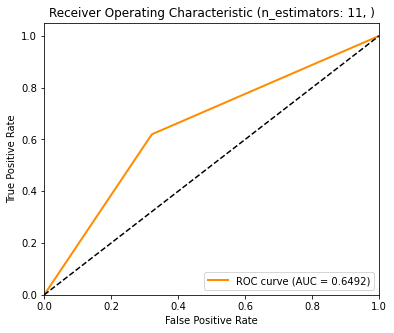

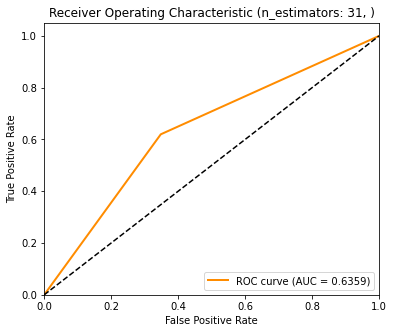

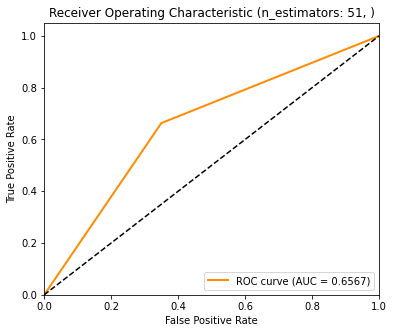

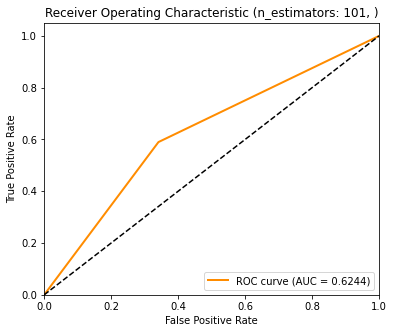

In [7]:
learner = DecisionTreeClassifier()
classifier = BaggingWithUndersampling(base_learner=learner)
param_grid = {'n_estimators': [11, 31, 51, 101]}

# Perform grid search
perform_grid_search(classifier, param_grid, X_train, y_train, X_test, y_test, n_iterations=10, plot_roc=True)

### HDDT

#### With under-sampling

Mean Evaluation Metrics:
+--------------+------------------+---------------+------------------+---------------+------------+-----------------+
| n_estimators | Precision (Mean) | Recall (Mean) | F-measure (Mean) | G-mean (Mean) | AUC (Mean) | Accuracy (Mean) |
+--------------+------------------+---------------+------------------+---------------+------------+-----------------+
|      11      |      0.1014      |     0.7033    |      0.177       |     0.6348    |   0.6417   |      0.5878     |
|      31      |      0.1062      |     0.7267    |      0.1851      |     0.6502    |   0.6572   |      0.5964     |
|      51      |      0.1023      |     0.6967    |      0.1783      |     0.6354    |   0.6393   |      0.5891     |
|     101      |      0.1169      |     0.7533    |      0.2021      |     0.6779    |   0.6827   |      0.621      |
+--------------+------------------+---------------+------------------+---------------+------------+-----------------+

Standard Deviation Evaluation 

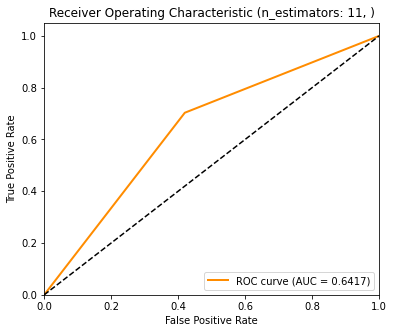

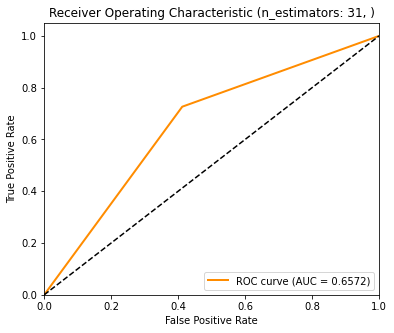

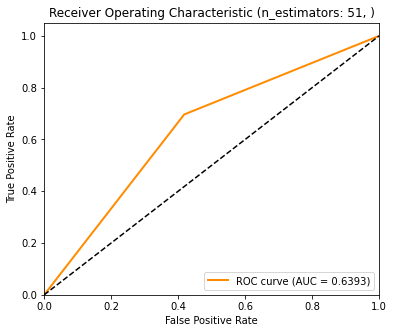

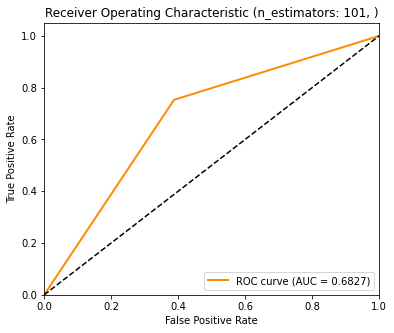

In [8]:
learner = HDDT(max_depth=25, cut_off_size=10)
classifier = BaggingWithUndersampling(base_learner=learner)
param_grid = {'n_estimators': [11, 31, 51, 101]}

# Perform grid search
perform_grid_search(classifier, param_grid, X_train, y_train, X_test, y_test, n_iterations=10, plot_roc=True)

#### Without under-sampling

Mean Evaluation Metrics:
+--------------+------------------+---------------+------------------+---------------+------------+-----------------+
| n_estimators | Precision (Mean) | Recall (Mean) | F-measure (Mean) | G-mean (Mean) | AUC (Mean) | Accuracy (Mean) |
+--------------+------------------+---------------+------------------+---------------+------------+-----------------+
|      11      |       0.2        |      0.1      |      0.1333      |     0.3119    |   0.5365   |      0.9181     |
|      31      |       0.2        |      0.1      |      0.1333      |     0.3119    |   0.5365   |      0.9181     |
|      51      |       0.2        |      0.1      |      0.1333      |     0.3119    |   0.5365   |      0.9181     |
|     101      |       0.2        |      0.1      |      0.1333      |     0.3119    |   0.5365   |      0.9181     |
+--------------+------------------+---------------+------------------+---------------+------------+-----------------+

Standard Deviation Evaluation 

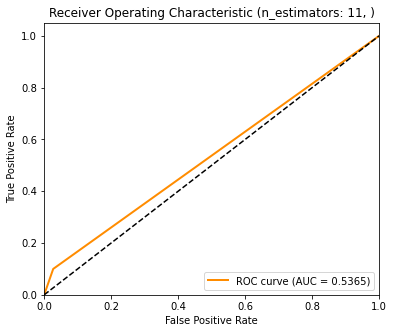

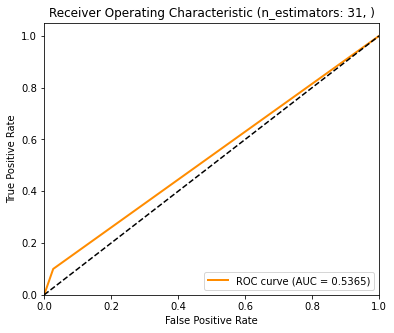

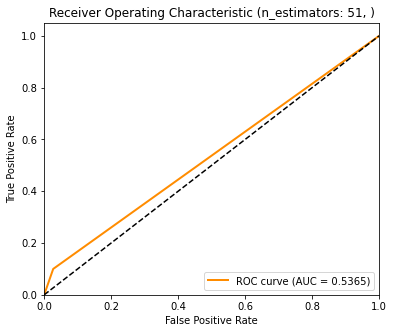

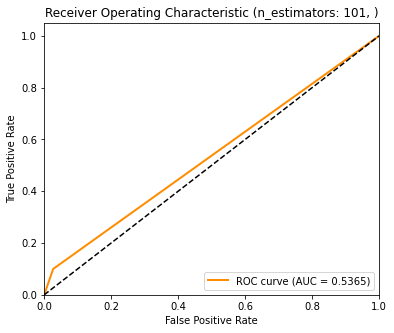

In [9]:
learner = HDDT(max_depth=25, cut_off_size=5)
classifier = BaggingWithUndersampling(base_learner=learner, disable_under_sampling=True)
param_grid = {'n_estimators': [11, 31, 51, 101]}

# Perform grid search
perform_grid_search(classifier, param_grid, X_train, y_train, X_test, y_test, n_iterations=2, plot_roc=True)

## AdaBoost

Mean Evaluation Metrics:
+--------------+--------+------------------+---------------+------------------+---------------+------------+-----------------+
| n_estimators | rounds | Precision (Mean) | Recall (Mean) | F-measure (Mean) | G-mean (Mean) | AUC (Mean) | Accuracy (Mean) |
+--------------+--------+------------------+---------------+------------------+---------------+------------+-----------------+
|      11      |   10   |      0.1095      |     0.6433    |      0.1866      |     0.6391    |   0.642    |      0.6408     |
|      11      |   15   |      0.1046      |     0.5733    |      0.1765      |     0.6147    |   0.6187   |      0.6584     |
|      31      |   10   |      0.1166      |     0.6533    |      0.1974      |     0.6567    |   0.6578   |      0.6618     |
|      31      |   15   |      0.1127      |     0.6467    |      0.1919      |     0.6508    |   0.652    |      0.6567     |
|      51      |   10   |      0.1155      |     0.6633    |      0.1963      |     0.

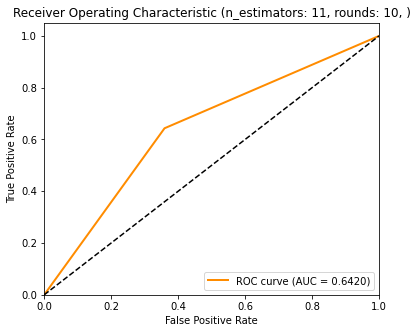

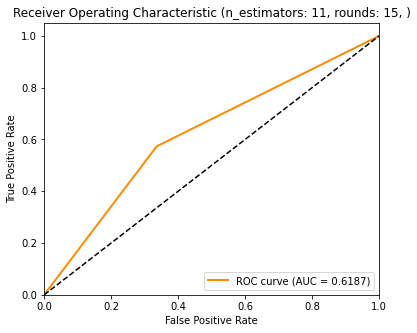

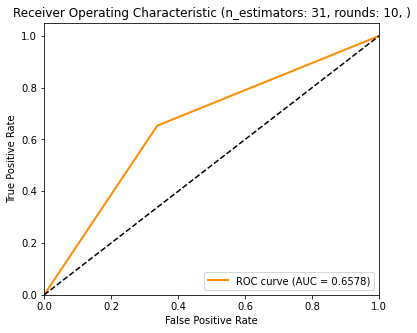

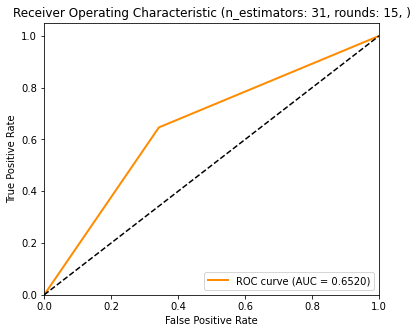

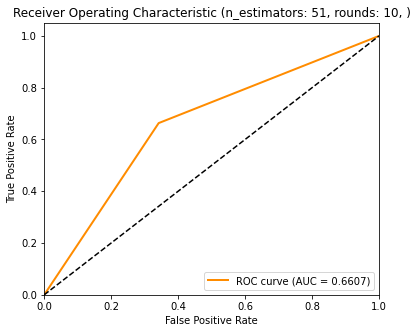

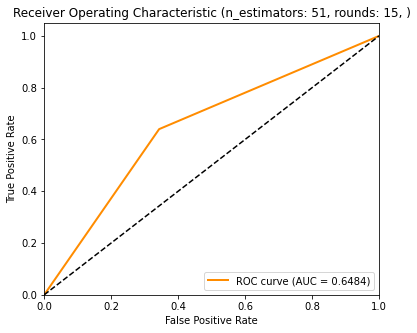

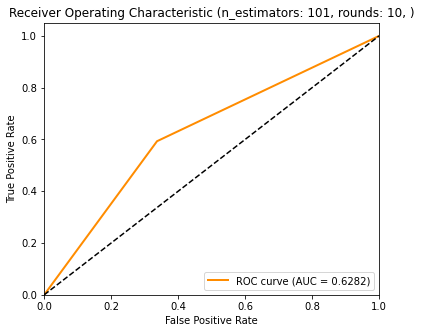

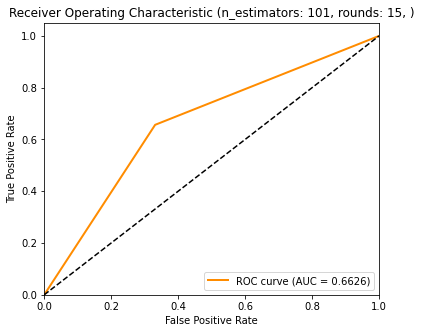

In [10]:
learner = DecisionTreeClassifier()
classifier = AdaBoostUnderSampling(base_learner=learner)
param_grid = {'n_estimators': [11, 31, 51, 101], 'rounds': [10, 15]}

# Perform grid search
perform_grid_search(classifier, param_grid, X_train, y_train, X_test, y_test, n_iterations=10, plot_roc=True)

In [ ]:
learner = HDDT(max_depth=12, cut_off_size=10)
classifier = AdaBoostUnderSampling(base_learner=learner)
param_grid = {'n_estimators': [11, 31, 51, 101], 'rounds': [10, 15]}

# Perform grid search
perform_grid_search(classifier, param_grid, X_train, y_train, X_test, y_test, n_iterations=10, plot_roc=True)